# Final Project

*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Sparse Interactions

### Preparation (3pts)

Review the paper [The Kernel Interaction Trick: Fast Bayesian Discovery of Pairwise Interactions in High Dimensions](https://arxiv.org/abs/1905.06501) by Agrawal et al. (2019). Start with the general concepts and then go into the finer details.

When you feel comfortable with the content, answer the following questions:

1. Why does the Gaussian scale mixture prior promote sparsity of the regression coefficients $\theta$?
2. What are the required properties of the model in Eq. (3) that allow it to be rewritten in the form of Eq. (6)?
3. What are the conceptual and practical limitation of the approach?

**Hint:** Some of the answers may require parsing the relevant references.

1. The priors of the regression coefficients $\theta$ are specified to be a zero-mean multivariate Gaussian distribution. The variance of the prior are hyperparameters $\alpha^{-1}$ (scale parameters) with priors being Gamma distributions with very small parameters (e.g. p($\alpha$) = $\prod_{i=0}^{N}Gamma(\alpha_i | a,b)$, where a=b=0). This setting allows the hyperpriors to be scale-invariant and uniform over a logarithmic scale. If the evidence from the data supports, the posterior probability mass of some alpha could concentrate at very large value, which forces the posterior distribution of the corresponding weights $w_i$ or $\theta_i$ to be concentrated at zero, which effectively eliminates the contribution of the corresponding regressors. Furthermore, one can set hard threshold on the weights for identifying active coefficients.

2. According Proposition 4.1, any generative model in the form of Eq(3) can be converted into the form of Eq(6).

3. One conceptual limitation of the approach is that it essentially assumes the model to be linear to the terms and their interactions. It will be interesting to see if the model can be extended to work for generalized linear models, which are widely applied in neuroscience. The practical limitation is, although SKIM runs in time linear in p per iteration, the cubic dependence on N still makes inference computationally challenging. Therefore, the method is better working with a dataset with small N. 

### Code adaptation (2pts)

The method SKIM from the paper's section 6 has been implemented in jax/Numpyro [here](https://pyro.ai/numpyro/examples/sparse_regression.html). Review the code and recognize how the theoretical concepts of the Kernel Interaction Trick and the specific features of SKIM have been implemented. Then copy the code to this notebook and modify it so that you can execute the provided test example inline. Confirm that you get a result comparable to theirs.

The last step of their example analysis (sampling from the posterior with the method `sample_theta_space`) often returns `nan`s. It also reports the posterior for all $\theta$ (active and inactive ones), and only for one sample at a time. That's really clunky. Modify this function to produce valid posterior samples of $\theta$ from all the $\tau$ samples from the MCMC step, but restrict yourself to the active direct and pairwise interaction terms. Visualize the posterior from the example with `corner`.

In [58]:
import argparse
import itertools
import os
import time

import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random
from jax.scipy.linalg import cho_factor, cho_solve, solve_triangular

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import corner
from math import comb

def dot(X, Z):
    return jnp.dot(X, Z[..., None])[..., 0]


# The kernel that corresponds to our quadratic regressor.
def kernel(X, Z, eta1, eta2, c, jitter=1.0e-4):
    eta1sq = jnp.square(eta1)
    eta2sq = jnp.square(eta2)
    k1 = 0.5 * eta2sq * jnp.square(1.0 + dot(X, Z))
    k2 = -0.5 * eta2sq * dot(jnp.square(X), jnp.square(Z))
    k3 = (eta1sq - eta2sq) * dot(X, Z)
    k4 = jnp.square(c) - 0.5 * eta2sq
    if X.shape == Z.shape:
        k4 += jitter * jnp.eye(X.shape[0])
    return k1 + k2 + k3 + k4


# Most of the model code is concerned with constructing the sparsity inducing prior.
def model(X, Y, hypers):
    S, P, N = hypers["expected_sparsity"], X.shape[1], X.shape[0]

    sigma = numpyro.sample("sigma", dist.HalfNormal(hypers["alpha3"]))
    phi = sigma * (S / jnp.sqrt(N)) / (P - S)
    eta1 = numpyro.sample("eta1", dist.HalfCauchy(phi))

    msq = numpyro.sample("msq", dist.InverseGamma(hypers["alpha1"], hypers["beta1"]))
    xisq = numpyro.sample("xisq", dist.InverseGamma(hypers["alpha2"], hypers["beta2"]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq

    lam = numpyro.sample("lambda", dist.HalfCauchy(jnp.ones(P)))
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    # compute kernel
    kX = kappa * X
    k = kernel(kX, kX, eta1, eta2, hypers["c"]) + sigma**2 * jnp.eye(N)
    assert k.shape == (N, N)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )


# Compute the mean and variance of coefficient theta_i (where i = dimension) for a
# MCMC sample of the kernel hyperparameters (eta1, xisq, ...).
# Compare to theorem 5.1 in reference [1].
def compute_singleton_mean_variance(X, Y, dimension, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((2, P))
    probe = probe.at[:, dimension].set(jnp.array([1.0, -1.0]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.50, -0.50])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Compute the mean and variance of coefficient theta_ij for a MCMC sample of the
# kernel hyperparameters (eta1, xisq, ...). Compare to theorem 5.1 in reference [1].
def compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((4, P))
    probe = probe.at[:, dim1].set(jnp.array([1.0, 1.0, -1.0, -1.0]))
    probe = probe.at[:, dim2].set(jnp.array([1.0, -1.0, 1.0, -1.0]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.25, -0.25, -0.25, 0.25])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Sample coefficients theta from the posterior for a given MCMC sample.
# The first P returned values are {theta_1, theta_2, ...., theta_P}, while
# the remaining values are {theta_ij} for i,j in the list `active_dims`,
# sorted so that i < j.
def sample_theta_space(X, Y, active_dims, msq, lam, eta1, xisq, c, sigma):
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    # the total number of coefficients we return
    num_coefficients = P + M * (M - 1) // 2

    probe = jnp.zeros((2 * P + 2 * M * (M - 1), P))
    vec = jnp.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = probe.at[start1 : start1 + 2, dim].set(jnp.array([1.0, -1.0]))
        vec = vec.at[start2, start1 : start1 + 2].set(jnp.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = probe.at[start1 : start1 + 4, dim1].set(
                jnp.array([1.0, 1.0, -1.0, -1.0])
            )
            probe = probe.at[start1 : start1 + 4, dim2].set(
                jnp.array([1.0, -1.0, 1.0, -1.0])
            )
            vec = vec.at[start2, start1 : start1 + 4].set(
                jnp.array([0.25, -0.25, -0.25, 0.25])
            )
            start1 += 4
            start2 += 1

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    L = cho_factor(k_xx, lower=True)[0]
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    mu = jnp.matmul(k_probeX, cho_solve((L, True), Y))
    mu = jnp.sum(mu * vec, axis=-1)

    Linv_k_probeX = solve_triangular(L, jnp.transpose(k_probeX), lower=True)
    covar = k_prbprb - jnp.matmul(jnp.transpose(Linv_k_probeX), Linv_k_probeX)
    covar = jnp.matmul(vec, jnp.matmul(covar, jnp.transpose(vec)))

    # sample from N(mu, covar)
    L = jnp.linalg.cholesky(covar)
    sample = mu + jnp.matmul(L, np.random.randn(num_coefficients))

    return sample

# Sample coefficients theta from the posterior for a given MCMC sample.
# This function returns a matrix of posterior samples of active thetas and interaction terms.
# For each column:
# The first p returned values are {theta_1, theta_2, ...., theta_p}, for the active direct thetas while
# the remaining values are {theta_ij} for i,j in the list `active_dims`,
# sorted so that i < j.
def sample_active_theta_space(X, Y, active_dims, msq, lam, eta1, xisq, c, sigma):
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    # the total number of coefficients
    num_coefficients = P + M * (M - 1) // 2
    # the total number of coefficients we want to return
    n_active_dims = len(active_dims)
    # convert active_dims to a boolean array
    active_dims = np.array(active_dims)
    active_dims_bool = np.zeros(num_coefficients, dtype=bool)
    active_dims_bool[active_dims] = True

    # Get the number of pairs of active dims
    n_pairs_active_dims = comb(n_active_dims,2)
    # Get the number of coefficients we want to return
    n_coeff_return = n_active_dims + n_pairs_active_dims
    # the total number of samples we want to return
    n_samples = msq.shape[0]
    # Create space for storing active theta_i and theta_ij
    theta_samples = np.zeros((n_samples, n_coeff_return))

    for sample_idx in range(n_samples):
        probe = jnp.zeros((2 * P + 2 * M * (M - 1), P))
        vec = jnp.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
        start1 = 0
        start2 = 0

        # Get other parameters from the sampler
        msq_sample = msq[sample_idx]
        lam_sample = lam[sample_idx]
        eta1_sample = eta1[sample_idx]
        xisq_sample = xisq[sample_idx]
        c_sample = c
        sigma_sample = sigma[sample_idx]

        for dim in range(P):
            probe = probe.at[start1 : start1 + 2, dim].set(jnp.array([1.0, -1.0]))
            vec = vec.at[start2, start1 : start1 + 2].set(jnp.array([0.5, -0.5]))
            start1 += 2
            start2 += 1

        for dim1 in active_dims:
            for dim2 in active_dims:
                if dim1 >= dim2:
                    continue
                probe = probe.at[start1 : start1 + 4, dim1].set(
                    jnp.array([1.0, 1.0, -1.0, -1.0])
                )
                probe = probe.at[start1 : start1 + 4, dim2].set(
                    jnp.array([1.0, -1.0, 1.0, -1.0])
                )
                vec = vec.at[start2, start1 : start1 + 4].set(
                    jnp.array([0.25, -0.25, -0.25, 0.25])
                )
                start1 += 4
                start2 += 1

        eta2 = jnp.square(eta1_sample) * jnp.sqrt(xisq_sample) / msq_sample
        kappa = jnp.sqrt(msq_sample) * lam_sample / jnp.sqrt(msq_sample + jnp.square(eta1_sample * lam_sample))

        kX = kappa * X
        kprobe = kappa * probe

        k_xx = kernel(kX, kX, eta1_sample, eta2, c_sample) + sigma_sample**2 * jnp.eye(N)
        L = cho_factor(k_xx, lower=True)[0]
        k_probeX = kernel(kprobe, kX, eta1_sample, eta2, c_sample)
        k_prbprb = kernel(kprobe, kprobe, eta1_sample, eta2, c_sample)

        mu = jnp.matmul(k_probeX, cho_solve((L, True), Y))
        mu = jnp.sum(mu * vec, axis=-1)

        Linv_k_probeX = solve_triangular(L, jnp.transpose(k_probeX), lower=True)
        covar = k_prbprb - jnp.matmul(jnp.transpose(Linv_k_probeX), Linv_k_probeX)
        covar = jnp.matmul(vec, jnp.matmul(covar, jnp.transpose(vec)))

        # sample from N(mu, covar)
        L = jnp.linalg.cholesky(covar)
        sample = mu + jnp.matmul(L, np.random.randn(num_coefficients))
        theta_samples[sample_idx, :n_active_dims] = sample[active_dims]
        theta_samples[sample_idx, n_active_dims:] = sample[P:]
        
    return theta_samples


# Helper function for doing HMC inference
def run_inference(model, args, rng_key, X, Y, hypers):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y, hypers)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc


# Get the mean and variance of a gaussian mixture
def gaussian_mixture_stats(mus, variances):
    mean_mu = jnp.mean(mus)
    mean_var = jnp.mean(variances) + jnp.mean(jnp.square(mus)) - jnp.square(mean_mu)
    return mean_mu, mean_var

# Create artificial regression dataset where only S out of P feature
# dimensions contain signal and where there is a single pairwise interaction
# between the first and second dimensions.
def get_data(N=20, S=2, P=10, sigma_obs=0.05):
    assert S < P and P > 1 and S > 0
    np.random.seed(0)

    X = np.random.randn(N, P)
    # generate S coefficients with non-negligible magnitude
    W = 0.5 + 2.5 * np.random.rand(S)
    # generate data using the S coefficients and a single pairwise interaction
    Y = (
        np.sum(X[:, 0:S] * W, axis=-1)
        + X[:, 0] * X[:, 1]
        + sigma_obs * np.random.randn(N)
    )
    Y -= jnp.mean(Y)
    Y_std = jnp.std(Y)

    assert X.shape == (N, P)
    assert Y.shape == (N,)

    return X, Y / Y_std, W / Y_std, 1.0 / Y_std


# Helper function for analyzing the posterior statistics for coefficient theta_i
def analyze_dimension(samples, X, Y, dimension, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_singleton_mean_variance(
            X, Y, dimension, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std


# Helper function for analyzing the posterior statistics for coefficient theta_ij
def analyze_pair_of_dimensions(samples, X, Y, dim1, dim2, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_pairwise_mean_variance(
            X, Y, dim1, dim2, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std


In [10]:
# Prepare inference
args = argparse.Namespace()
args.num_samples = 1000
args.num_warmup = 500
args.num_chains = 1
args.num_data = 100
args.num_dimensions = 20
args.active_dimensions = 3
args.device = "cpu"
numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)
X, Y, expected_thetas, expected_pairwise = get_data(
    N=args.num_data, P=args.num_dimensions, S=args.active_dimensions
)

# setup hyperparameters
hypers = {
    "expected_sparsity": max(1.0, args.num_dimensions / 10),
    "alpha1": 3.0,
    "beta1": 1.0,
    "alpha2": 3.0,
    "beta2": 1.0,
    "alpha3": 1.0,
    "c": 1.0,
}

# do inference
rng_key = random.PRNGKey(0)
mcmc = run_inference(model, args, rng_key, X, Y, hypers)
samples = mcmc.get_samples()


sample: 100%|██████████| 1500/1500 [00:51<00:00, 28.88it/s, 15 steps of size 1.79e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.00      0.00      0.00      0.00      0.00    321.25      1.00
 lambda[0]   3534.53  20843.19    898.32     92.36   4975.63    415.49      1.00
 lambda[1]   7568.09  53513.83   1174.78     93.34   6327.38    350.41      1.00
 lambda[2]    310.26    442.61    194.24     27.99    614.15    404.71      1.00
 lambda[3]      1.24      1.84      0.71      0.00      3.01    876.77      1.00
 lambda[4]      1.30      2.07      0.78      0.00      2.71    825.84      1.00
 lambda[5]      1.28      2.00      0.73      0.00      2.71    660.76      1.00
 lambda[6]      1.88      3.10      1.04      0.00      4.24    845.16      1.00
 lambda[7]      1.46      1.83      0.91      0.00      3.38    967.62      1.00
 lambda[8]      1.10      1.37      0.68      0.00      2.61    939.79      1.00
 lambda[9]      1.39      2.01      0.79      0.00      3.35   1312.12      1.00
lambda[10]      1.38      1

In [65]:
# compute the mean and square root variance of each coefficient theta_i
means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
    jnp.arange(args.num_dimensions)
)

print(
    "Coefficients theta_1 to theta_%d used to generate the data:"
    % args.active_dimensions,
    expected_thetas,
)
print(
    "The single quadratic coefficient theta_{1,2} used to generate the data:",
    expected_pairwise,
)
active_dimensions = []

for dim, (mean, std) in enumerate(zip(means, stds)):
    # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
    lower, upper = mean - 3.0 * std, mean + 3.0 * std
    inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
    if inactive == "active":
        active_dimensions.append(dim)
    print(
        "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
        % (dim + 1, args.num_dimensions, inactive, mean, std)
    )

print(
    "Identified a total of %d active dimensions; expected %d."
    % (len(active_dimensions), args.active_dimensions)
)

# Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
# Note that the resulting numbers are only meaningful for i != j.


if len(active_dimensions) > 0:
    dim_pairs = jnp.array(
        list(itertools.product(active_dimensions, active_dimensions))
    )
    means, stds = vmap(
        lambda dim_pair: analyze_pair_of_dimensions(
            samples, X, Y, dim_pair[0], dim_pair[1], hypers
        )
    )(dim_pairs)
    # Store the active dimension pairs in a list
    active_dimensions_pairs = np.array([])
    for dim_pair, mean, std in zip(dim_pairs, means, stds):
        dim1, dim2 = dim_pair
        if dim1 >= dim2:
            continue
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        if not (lower < 0.0 and upper > 0.0):
            active_dimensions_pairs = np.append(active_dimensions_pairs, dim_pair)
            format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
            print(format_str % (dim1 + 1, dim2 + 1, mean, std))

    # Draw a single sample of coefficients theta from the posterior, where we return all singleton
    # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
    # final MCMC sample obtained from the HMC sampler.
    thetas = sample_theta_space(
        X,
        Y,
        active_dimensions,
        samples["msq"][-1],
        samples["lambda"][-1],
        samples["eta1"][-1],
        samples["xisq"][-1],
        hypers["c"],
        samples["sigma"][-1],
    )
    print("Single posterior sample theta:\n", thetas)

    # Draw samples (n=num_samples) of active thetas and their pairwise interactions from the posterior.
    thetas_active_theta_and_their_pairwise_interaction = sample_active_theta_space(
        X,
        Y,
        active_dimensions,
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        hypers["c"],
        samples["sigma"],
    )

Coefficients theta_1 to theta_3 used to generate the data: [0.69618857 0.7082517  0.35156995]
The single quadratic coefficient theta_{1,2} used to generate the data: 0.4637312
[dimension 01/20]  active:	6.88e-01 +- nan
[dimension 02/20]  active:	7.06e-01 +- 1.25e-02
[dimension 03/20]  active:	3.53e-01 +- 8.03e-03
[dimension 04/20]  inactive:	2.51e-04 +- 7.16e-03
[dimension 05/20]  inactive:	-4.08e-04 +- 7.19e-03
[dimension 06/20]  inactive:	-2.04e-04 +- 7.16e-03
[dimension 07/20]  inactive:	1.47e-03 +- 7.37e-03
[dimension 08/20]  inactive:	-8.88e-04 +- 7.23e-03
[dimension 09/20]  inactive:	-4.50e-04 +- 7.17e-03
[dimension 10/20]  inactive:	-2.24e-04 +- 7.19e-03
[dimension 11/20]  inactive:	6.04e-04 +- 7.22e-03
[dimension 12/20]  inactive:	-1.94e-03 +- 7.39e-03
[dimension 13/20]  inactive:	7.80e-04 +- 7.24e-03
[dimension 14/20]  inactive:	1.41e-04 +- 7.16e-03
[dimension 15/20]  inactive:	1.49e-04 +- 7.15e-03
[dimension 16/20]  inactive:	3.35e-04 +- 7.21e-03
[dimension 17/20]  inactive:	

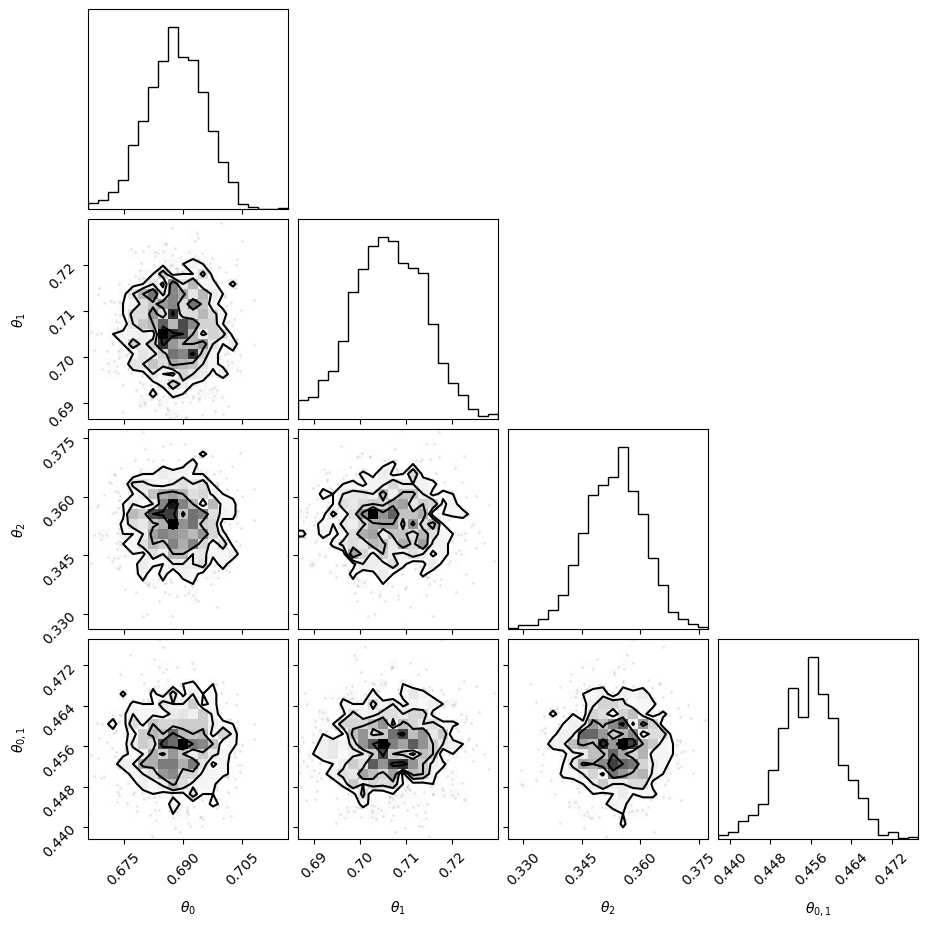

In [66]:
# Do the corner plot
# Get active thetas and their labels
thetas_active_theta_and_active_pairwise_interaction = thetas_active_theta_and_their_pairwise_interaction[:, : len(active_dimensions)]
labels = [r"$\theta_{%d}$" % i for i in active_dimensions] 

# Create an index for each pair of active dimensions
k = 0
for i in active_dimensions:
    for j in active_dimensions:
        if i == active_dimensions_pairs[0] and j== active_dimensions_pairs[1]:
            thetas_active_theta_and_active_pairwise_interaction = np.append(thetas_active_theta_and_active_pairwise_interaction, thetas_active_theta_and_their_pairwise_interaction[:, len(active_dimensions) + k].reshape(-1, 1), axis=1)
            labels.append(r"$\theta_{%d,%d}$" % (i, j))
fig = corner.corner(
    thetas_active_theta_and_active_pairwise_interaction, 
    labels=labels
);

### Application (5pts)

Find an application from your area of research where the kernel-interaction method is directly applicable, or could be applied with some modification. Describe the application for a statistically knowledgeable but non-expert audience (think: your peers in SML 505). In particular, explain why the sparse interaction ansatz is justified. Then demonstrate the use with a suitable data set of your own choice. Explain what you find.

This task has three parts:

* Identify and descuss which possible effects there could be.
* Find suitable data.
* Perform the inference and interpret the results.

You will probably need to iterate and refine along the way. Explain your reasoning about the kinds of features you decided to include in your analysis. Then report the most important direct and pairwise interactions. Visualized the posterior samples with `corner`.

**Note:** This is an exploratory study. If your approach is sound, but the data don't show firm trends, points will be awarded. Make sure that you have permission to use the data and include it as separate file in your submission.

**Hint:** Don't forget to standardize the data by subtracting the mean and dividing by the standard deviation.

In [55]:

import os
import argparse
from glob import glob
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define helper function for getting data
def load_data(data_path):
    data = {}
    nwb = NWBHDF5IO(data_path, mode='r').read()
    trial_info = nwb.intervals['trials']
    data['subj'] = nwb.subject.subject_id
    data['description'] = nwb.experiment_description
    data['rois'] = np.asarray(nwb.electrodes['location'].data)
    data['confidence'] = np.array(trial_info.response_value.data)
    data['condition'] = np.array(trial_info.stim_phase)
    data['category'] = np.array(trial_info.stimCategory.data)
    data['onset'] = np.array(trial_info.start_time.data)
    data['recog_novelty'] = np.array(trial_info.new_old_labels_recog)
    data['unit_electrodes'] = np.array(nwb.units['electrodes'].data)
    # Convert the spike times to stimulus spike counts.
    n_units = data['unit_electrodes'].shape[0]
    n_stimuli = data['category'].shape[0]
    spike_counts = np.zeros([n_stimuli, n_units])
    for i in range(n_units):
        spks = nwb.units.get_unit_spike_times(i)
        spike_counts[:,i] = np.array([((spks>onset)&(spks<onset+1)).sum() for onset in data['onset']+.2])
    data['spike_counts'] = zscore(spike_counts, 0)
    return data

## Data visualization
Here, we are showing the neuronal response (normalized firing rate) as the subject was shown different visual stimuli. The visual stimuli were presented during two phases: 1. encoding phase (subjects indicated for each image whether it contained an animal or not (yes or no)); 2. recognition phase (subjects indicated whether they thought that the image was “novel” (never seen before)). In the left panel, color indicates the normalized firing rate of each neuron in a trial (during which one stimulus was shown). On the left, color represents the stimulus category (dark purple: encoding phase; yellow: reconition phase).

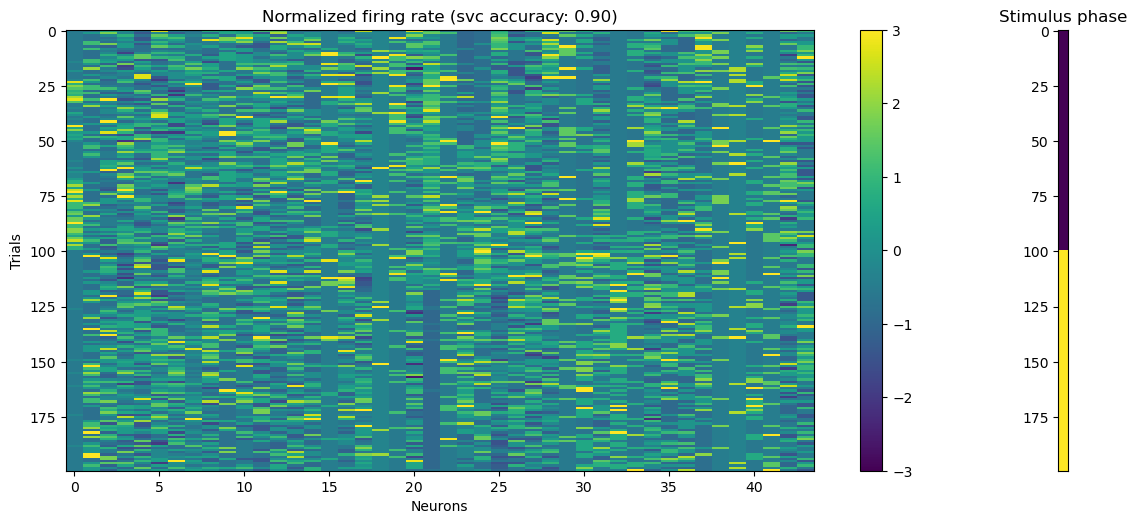

In [70]:
# Load P38CS_NOID102 data
path = './data/P38CS_NOID102.nwb'
data = load_data(path)
# Evaluate the quality of the data.
subj = data['subj']
X, Y = data['spike_counts'], (data['condition']=='recog').astype(int)
# Normalize neurons' response
X = np.subtract(data['spike_counts'],data['spike_counts'].mean(0))
X = np.divide(X, data['spike_counts'].std(0))
nCells = X.shape[1]
nStimuli = X.shape[0]

# Do a simple SVM just to verify data
clf = svm.SVC(kernel='linear', C=1, random_state=88)
scores = cross_val_score(clf, X, Y, cv=10)
session = path.split('/')[-1].split('.')[0]
# all_scores.append(scores.mean())
# Visualize data
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.tight_layout()
# axes[0].imshow(X, aspect='auto', interpolation='none',clim=[-2,2])
axes[0].set_title(f'Normalized firing rate (svc accuracy: {scores.mean():.2f})')
axes[0].set_xlabel('Neurons')
axes[0].set_ylabel('Trials')
# color bar
cbar = fig.colorbar(axes[0].imshow(X, aspect='auto', interpolation='none',clim=[-3,3]),ax=axes[0])

# Plot the stimulus category
axes[1].imshow(Y.reshape(-1,1), aspect='auto', interpolation='none',clim=[0, 1])
axes[1].set_title('Stimulus phase')
# Make the second subplot smaller
box = axes[1].get_position()
axes[1].set_position([box.x0, box.y0, box.width * 0.01, box.height])
# remove x label
axes[1].set_xticks([]);

In [59]:
# Run SKIM

args = argparse.Namespace()
args.num_samples = 1000
args.num_warmup = 500
args.num_chains = 1
args.num_data = nStimuli
args.num_dimensions = nCells
# args.active_dimensions = 3
args.device = "cpu"
numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)


# setup hyperparameters
hypers = {
    "expected_sparsity": max(1.0, args.num_dimensions / 10),
    "alpha1": 3.0,
    "beta1": 1.0,
    "alpha2": 3.0,
    "beta2": 1.0,
    "alpha3": 1.0,
    "c": 1.0,
}

# do inference
rng_key = random.PRNGKey(0)
mcmc = run_inference(model, args, rng_key, X, Y, hypers)
samples = mcmc.get_samples()


sample: 100%|██████████| 1500/1500 [04:36<00:00,  5.43it/s, 15 steps of size 1.65e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.01      0.00      0.01      0.00      0.01    419.48      1.00
 lambda[0]     61.78    325.45     29.59      6.98     76.95    632.94      1.00
 lambda[1]      0.89      1.02      0.60      0.01      1.96    961.50      1.00
 lambda[2]      0.89      1.00      0.61      0.00      1.85   1011.01      1.00
 lambda[3]      0.93      1.03      0.64      0.00      2.00   1291.54      1.00
 lambda[4]      0.89      1.13      0.59      0.00      1.97    772.67      1.00
 lambda[5]      3.93      3.27      3.11      0.01      7.99   1117.10      1.00
 lambda[6]      1.27      1.34      0.88      0.01      2.89    792.64      1.00
 lambda[7]      0.86      0.98      0.62      0.00      1.80   1089.29      1.00
 lambda[8]      2.17      2.29      1.48      0.01      4.85    832.87      1.00
 lambda[9]      1.68      2.87      0.84      0.00      3.94   1025.57      1.00
lambda[10]      1.09      1

In [62]:
# compute the mean and square root variance of each coefficient theta_i
means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
    jnp.arange(args.num_dimensions)
)

active_dimensions = []

for dim, (mean, std) in enumerate(zip(means, stds)):
    # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
    lower, upper = mean - 3.0 * std, mean + 3.0 * std
    inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
    if inactive == "active":
        active_dimensions.append(dim)
    print(
        "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
        % (dim + 1, args.num_dimensions, inactive, mean, std)
    )

print(
    "Identified a total of %d active dimensions."
    % (len(active_dimensions))
)

# Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
# Note that the resulting numbers are only meaningful for i != j.

if len(active_dimensions) > 0:
    dim_pairs = jnp.array(
        list(itertools.product(active_dimensions, active_dimensions))
    )
    means, stds = vmap(
        lambda dim_pair: analyze_pair_of_dimensions(
            samples, X, Y, dim_pair[0], dim_pair[1], hypers
        )
    )(dim_pairs)
    # Store the active dimension pairs in a list
    active_dimensions_pairs = np.array([])
    for dim_pair, mean, std in zip(dim_pairs, means, stds):
        dim1, dim2 = dim_pair
        if dim1 >= dim2:
            continue
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        if not (lower < 0.0 and upper > 0.0):
            active_dimensions_pairs = np.append(active_dimensions_pairs, dim_pair)
            format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
            print(format_str % (dim1 + 1, dim2 + 1, mean, std))

    # Draw samples (n=num_samples) of active thetas and their pairwise interactions from the posterior.
    thetas_active_theta_and_their_pairwise_interaction = sample_active_theta_space(
        X,
        Y,
        active_dimensions,
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        hypers["c"],
        samples["sigma"],
    )

[dimension 01/44]  active:	-2.59e-01 +- 4.35e-02
[dimension 02/44]  inactive:	-7.01e-04 +- 1.00e-02
[dimension 03/44]  inactive:	5.40e-04 +- 9.89e-03
[dimension 04/44]  inactive:	1.42e-03 +- 1.02e-02
[dimension 05/44]  inactive:	1.03e-03 +- 9.97e-03
[dimension 06/44]  inactive:	-3.09e-02 +- 2.03e-02
[dimension 07/44]  inactive:	-7.51e-03 +- 1.32e-02
[dimension 08/44]  inactive:	-4.11e-05 +- 1.00e-02
[dimension 09/44]  inactive:	1.44e-02 +- 1.71e-02
[dimension 10/44]  inactive:	-5.19e-03 +- 1.32e-02
[dimension 11/44]  inactive:	-1.73e-03 +- 1.06e-02
[dimension 12/44]  inactive:	-2.90e-03 +- 1.08e-02
[dimension 13/44]  inactive:	1.21e-03 +- 1.06e-02
[dimension 14/44]  inactive:	-1.55e-04 +- 1.03e-02
[dimension 15/44]  inactive:	-1.32e-03 +- 1.01e-02
[dimension 16/44]  inactive:	-4.87e-03 +- 1.30e-02
[dimension 17/44]  inactive:	1.37e-02 +- 1.73e-02
[dimension 18/44]  inactive:	1.37e-03 +- 1.04e-02
[dimension 19/44]  inactive:	-2.02e-03 +- 1.03e-02
[dimension 20/44]  inactive:	-3.12e-03 +

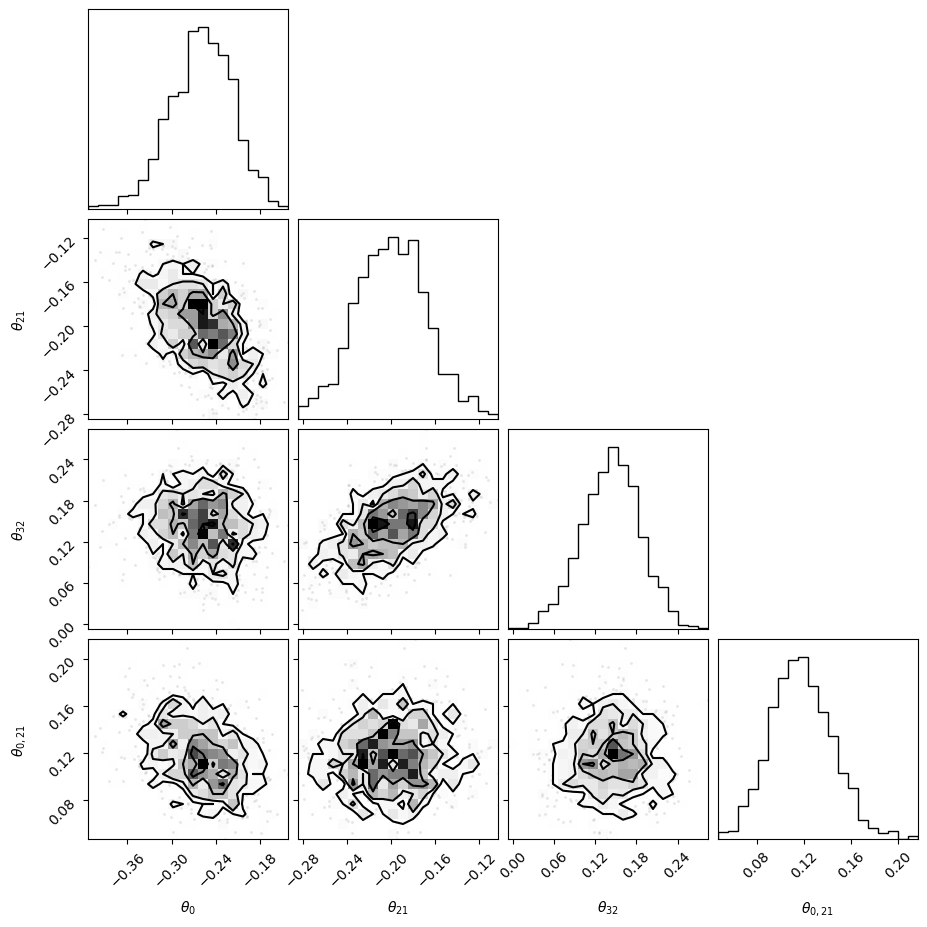

In [63]:
# Do the corner plot
# Get active thetas and their labels
thetas_active_theta_and_active_pairwise_interaction = thetas_active_theta_and_their_pairwise_interaction[:, : len(active_dimensions)]
labels = [r"$\theta_{%d}$" % i for i in active_dimensions] 

# Create an index for each pair of active dimensions
k = 0
for i in active_dimensions:
    for j in active_dimensions:
        if i == active_dimensions_pairs[0] and j== active_dimensions_pairs[1]:
            thetas_active_theta_and_active_pairwise_interaction = np.append(thetas_active_theta_and_active_pairwise_interaction, thetas_active_theta_and_their_pairwise_interaction[:, len(active_dimensions) + k].reshape(-1, 1), axis=1)
            labels.append(r"$\theta_{%d,%d}$" % (i, j))
fig = corner.corner(
    thetas_active_theta_and_active_pairwise_interaction, 
    labels=labels
);

# Final Project report


## Introduction

Human medial temporal lobe (MTL) has been suggested to be essential in memory encoding and processing. However, it is not known whether single neurons in the MTL are directly tuned to (i.e. show specific response to) the distinct phases of memory processing. In this final project, we investigated how single neurons recorded in human MTL respond during the two distinct phases of memory processing - encoding and recognition (Chandravadia, N., Liang, D., Schjetnan, A.G.P. et al., 2020). Using a statistical method (sparse kernel interaction model (SKIM); Agrawal and Broderick et al., 2022), we identified neurons that show distinct and specific response during different phases of memory and discovered a pairwise interaction between two neurons. 

## Methods
We acquired the data (an example session from a single human subject) from Chandravadia, N., Liang, D., Schjetnan, A.G.P. et al. 2020. The dataset is comprised with the intracranial recording from epilepsy patients during the waiting period for seizure events to occur. Activity (spikes, or firing) of single neurons were successfully identified by Chandravadia et al. (2020). The subjects were instructed to perform a task of encoding and recognizing visual stimulus. In the encoding phase, 100 novel images from different visual categories (houses, landscapes, mobility, phones, animals, fruits, kids, military, space, cars, food, people, and spatial) were presented to the patients. Following the encoding phase, in the recognition phase, subjects were presented with 50 “novel” images and 50 “old” images. During the recognition phase, subjects choosed whether they considered that the image was “novel” (never seen before), or “old” (seen during encoding). They were also instructed to report a confidence ratings on a 1–6 scale regarding their choice. During the encoding phase, subjects indicated for each image whether it contained an animal or not (yes or no). Because we mainly focused on the encoding phase of the task, the categories of the visual stimuli and the confidence report did not play further role in our analysis.

We specifically analyzed the data from a single session from a subject (P38CS_NOID102). Naively, we could model the neuronal representation of task phases (embedded as 0 or 1 depending on whether it was during the encoding or decoding phase) using a simple linear regression model: we could predit the task phase (either encoding or recognition) using a linear combination of the firing rate of the neurons plus some noise:

$$
y^{(n)} = \theta^T\Phi _{2}(x^{(n)}) + \epsilon
$$

where $y^{(n)}$ is the $n_{th}$ category visual stimulus, $\theta$ is the vector of weights for each neuron, $\epsilon$ is Gaussian noise with zero mean, and $\Phi _{2}(x^{(n)})$ is the design matrix:

$$
\Phi _{2}(x^{(n)}) := [1, x_1, ..., x_p] 
$$

However, neurons in a neuronal network are normally related to each other either through direct synaptic connections or indirect neuronal projections. Therefore, it is unlikely that neurons in the recorded neuronal population are entirely independent from each other when a specific stimulus is presented. To tease out these pairwise interaction effects in our regression model, we needed a model that can include the $x_i \cdot x_j$ terms:

$$
\Phi _{2}(x^{(n)}) := [1, x_1, ..., x_p, x_1^2, x_1x_2, ..., x_p^2] 
$$

Traditional Bayesian approaches for including the interaction terms are often computationally costly or intractable even for problems with small dimensionality. Here, we applied the sparse kernel interaction model (SKIM; Agrawal and Broderick et al., 2022) to solve these issues. As a Bayesian approach in essence, SKIM has several benefits:
1. Background knowledge about the parameters can be incorperated into the model through priors.
2. The method will sample the posterior distribution of the parameters of interest, which provides us with statitical quantification of confidence intervals.
3. The model will promote the sparsity of the regression coefficient $\theta$, which allows us to identify neurons that categorically encode the task phases and disgard the rest. Furthermore, the active pairwise interaction terms will identify the pair of neurons whose activities are correlated and are highly predictive of the task phase.

## Results and conclusion
Considering the above benefits, we applied the SKIM model on the dataset and identified three active weights ($\theta_{0}, \theta_{21}$, and $\theta_{32}$) associated with three neurons (0, 21, and 32). Investigating the normalized firing rate plot of these neurons, it could be observed that they exhibited task-phase-specific firing patterns. Specifically, neuron 0 and neuron 21 had a higher firing rate during the first task phase (embedded as 0), while they had a lower firing rate during the second task phase (embedded as 1). This corresponds to the negative weights for these two neurons ($\theta_{0} = -2.59\times 10^{-1} \pm 4.35\times 10^{-2}$ and $\theta_{21} = -1.99\times 10^{-1} \pm 3.22\times 10^{-2}$). On the contrary, neuron 32 showed increasing firing rate during the second task phase, and it has a positive regression weight ($\theta_{32} = 1.45\times 10^{-1} \pm 4.23\times 10^{-2}$). 

From the normalized firing rate plot, we also identified that the firing rate of neuron 0 and neuron 21 seemed to be positively correlated. This observation was confirmed by the SKIM output, that $\theta_{0, 21} = 1.18\times 10^{-1} \pm 2.57\times 10^{-2}$. Therefore, SKIM allowed us to quantitatively capture the pairwised interaction effects in the neuronal recording data.

## References

Chandravadia, N., Liang, D., Schjetnan, A.G.P. et al. A NWB-based dataset and processing pipeline of human single-neuron activity during a declarative memory task. Sci Data 7, 78 (2020). https://doi.org/10.1038/s41597-020-0415-9

Agrawal, Raj, et al. "The kernel interaction trick: Fast Bayesian discovery of pairwise interactions in high dimensions." International Conference on Machine Learning. PMLR, 2019.

